In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib notebook
from plotting import plot_folded_lightcurve
import george
import scipy.stats

In [130]:
def read_data(filename, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=False)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]
    data_pts = len(tsample)

    return tsample, fsample, flux_err, data_pts

def generate_gp(params, fsample, flux_err):

    """
    Sets up the initial parameters for all the walkers using optimized
    parameter values as starting values. The function generates a
    scattered multivatiate gaussian distribution of starting parameter
    values.

    Parameters
    ----------
    params : list
        List of all kernel parameters.

    Returns
    -------
    p0 : numpy.ndarray
        The initial walker parameters [nwalker, ndim]

    gp : george.gp.GP
        GP kernel set with the optimized parameter values.

    """


    gp_mean, log_amp, gamma, log_period = params
    amp = np.exp(log_amp)

    kernel = amp * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
    gp.compute(fsample, flux_err)

    return gp

def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None,
                      ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in hours**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period - np.floor((time-t0)/period)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="data")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="data")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period - np.floor(true_time/period)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="true light curve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1])
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1])

    if models:
        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period) - np.floor(m_time/period)
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]


        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1, c=colours[2])
                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2])

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Plot")
    period_hours = period
    ax.set_title(r"period $P = %.3f$"%period_hours)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax

### Import all the necessary data files

Results that have high gamma values include:

../data/221_lc_49627_to_49787.txt_sampled_semi-dense_60days_equal_dist_results.txt

../data/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days_equal_dist_results.txt

../data/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_60days_equal_dist_results.txt

Set the results file equal to one of the results above. 

In [164]:
results_file = "../data/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days_equal_dist_results.txt"
results = np.genfromtxt(results_file, delimiter=' ')

### Now import the corresponding sample file that the results were generated from

Just remove the text saying "_results.txt"

In [165]:
sample_file = "../data/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days_equal_dist"

tsample, fsample, flux_err, data_pts = read_data(sample_file)
results = results.reshape(100,10000,4)

days = 60

### Lastly, import the original data file with all the original data

This way we have an idea of what the true light curve is

In [166]:
data_file = "../data/221_lc_49627_to_49787.txt"
data = pd.read_csv(data_file, delimiter=' ', header=None, names=['time','flux'], dtype={'time':float, 'flux':float})

# convert days to points
span = 2880 * days
start_pt = 0

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

true_lightcurve = [time, flux]

### We can now find all the walker indices that have a large gamma value as at their last step

In [168]:
results[:, 9999, 2]
idx = np.where(results[:, 9999, 2] > 3000)
idx

#results[:, 9999, 2]

(array([ 0,  3,  4,  5, 23, 44, 47, 48, 50, 99]),)

### Let's use the first index to create a model

In [169]:
params = results[idx[0][1],9999,:] # 3rd walker has highest gamma value
period = np.exp(params[3])*24.

print("period in hours : " + str(period)) 

period in hours : 3.0377531027905427


### Calculate the prior gamma values

In [171]:
gp = generate_gp(params, fsample, flux_err)
gp.set_parameter_vector(params)
gp.compute(tsample, flux_err)
lnlike = gp.lnlikelihood(fsample)
print("lnLikelihood : " + str(lnlike))

p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
print("Gamma value : " + str(params[2]))
print("Prior value : " + str(p_log_gamma))

lnLikelihood : 329.7911910077563
Gamma value : 3021.3159376540566
Prior value : -0.5524256126230083


### Let's  compare this to a walker that has a normal gamma value

In [82]:
params = results[2,9999,:] # 3rd walker has highest gamma value
period = np.exp(params[3])*24.

print("period in hours : " + str(period)) 

gp = generate_gp(params, fsample, flux_err)
gp.set_parameter_vector(params)
gp.compute(tsample, flux_err)
lnlike = gp.lnlikelihood(fsample)
print("lnLikelihood : " + str(lnlike))

p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
print("Gamma value : " + str(params[2]))
print("Prior value : " + str(p_log_gamma))

period in hours : 10.440205641360851
lnLikelihood : 434.13026521623783
Gamma value : 26.483895187668505
Prior value : -1.5396001521215323


### We can now plot what the folded lc would look like

[0]
[ 1.06739993e+00 -4.73773609e+00  7.94766861e+03 -9.68114798e-01]


<IPython.core.display.Javascript object>


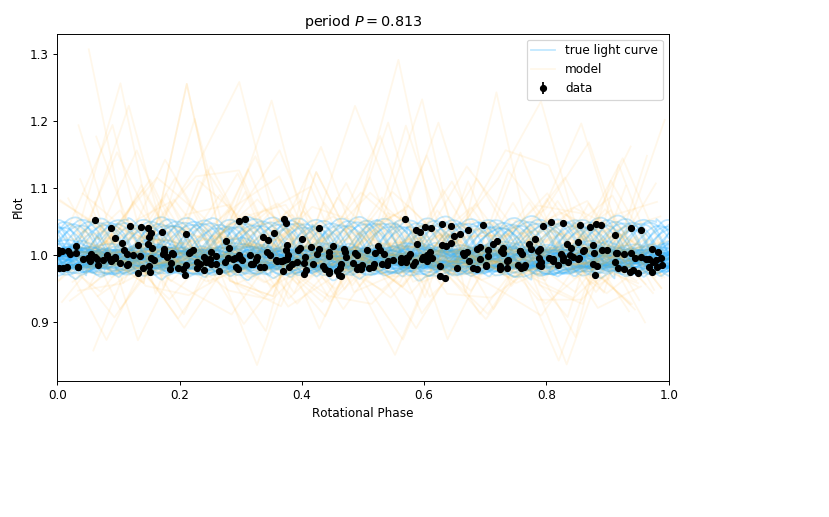

In [158]:
nmodels = 1
idx_temp = np.zeros(1,dtype=int)
print(idx_temp)

t_pred = np.linspace(tsample[0], tsample.iloc[-1], 1000)
m_all = np.zeros((nmodels, t_pred.shape[0]))

#gp = generate_gp(params, fsample, flux_err)

for i,j in enumerate(idx_temp):
    p = results[j,9999,:]
    print(p)
    pnew = [p[0], p[1], p[2], p[3]]

    gp.set_parameter_vector(pnew)
    mean_model = gp.sample_conditional(fsample, t_pred)
    m_all[i] = mean_model
    
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax = plot_folded_lightcurve(tsample, fsample, period, flux_err=flux_err,
                      models=[t_pred, m_all[:2]],
                      true_lightcurve=true_lightcurve, ax=ax, use_radians=False)

namestr = 'test'

plt.tight_layout()
plt.show()
#plt.savefig(namestr + "_folded_lc.pdf", format="pdf")